___
<h1 align="center"><strong>Projet télédétection avancée</strong></h1>

<p align="center"><strong>Jeu de données :</strong> Pyrénées 2024-2025</p>
<p align="center"><strong>Auteur :</strong> Lisa Ventura</p>


---

## **1. Configuration de l’environnement et des données**

### Objectif

Ce bloc a pour objectif d’**initialiser l’environnement de travail** et de définir l’ensemble des données nécessaires au traitement des images Sentinel-2 dans le cadre du projet.

### Contenu du bloc

Il comprend :
- l’importation des **bibliothèques standards**,
- le chargement des **modules géospatiaux** et des **fonctions personnalisées** dédiées au projet dans la bibliothèque *libsigma*,
- la mise en place de **l’arborescence de travail**,
- la définition des chemins vers :
  - les données raster (bandes spectrales Sentinel-2),
  - les données vecteur de référence terrain (shapefile des strates),
  - le raster de sortie pour l’indice ARI.

### Préparation de l’analyse

- Enfin, ce bloc construit dynamiquement la liste des bandes spectrales utilisées pour l’analyse multi-bandes. Les dates d'acquisition sont ensuite listées.
---


In [1]:
# Import de bibliothèques standards
import sys, os, numpy as np, pandas as pd
sys.path.append('..')
from osgeo import gdal
gdal.UseExceptions()
import matplotlib.pyplot as plt
import logging
import warnings

#Bibliothèques personnelles
import my_function as my
from libsigma import classification as cl

#Création des dossiers de stockage des résultats
my.creation_dossier()
ari_path = '../results/ARI_serie_temp.tif'

#Définition du chemin d'accès aux données
data_dir = '../data/projet_eval'
shp_path = os.path.join(data_dir, 'PI_strates_pyrenees_32630.shp')
b03_path = os.path.join(data_dir, 'pyrenees_24-25_B03.tif')
b05_path = os.path.join(data_dir, 'pyrenees_24-25_B05.tif')
b04_path = os.path.join(data_dir, 'pyrenees_24-25_B04.tif')
b02_path = os.path.join(data_dir, 'pyrenees_24-25_B02.tif')

# Liste dynamique des chemins vers les fichiers des rasters sentinel-2
liste_fichiers_bandes = [f"{data_dir}/pyrenees_24-25_B{b}.tif" for b in ["02",
"03","04","05","06","07",
"08","8A","11","12"]]

#Liste des dates d'acquisition des données
dates = ["11/10/24", "21/10/24", "28/11/24", "05/12/24", "14/01/25", "23/02/25",
 "29/05/25", "18/06/25", "16/07/25", "24/08/25"]

Dossier vérifié/créé : /home/onyxia/work/results
Dossier vérifié/créé : /home/onyxia/work/results/figure


---

## **2. Rasterisation des données vecteur et analyse des données d’entrée**

### Objectif

Cette étape vise à transformer les données vecteur issues du terrain (shapefile des strates) en rasters alignés sur les images Sentinel-2, afin de les rendre exploitables pour les traitements raster et les phases de classification supervisée.

### Contenu du bloc

Les opérations réalisées sont les suivantes :

- **Rasterisation des strates**  
  Le shapefile est converti en raster selon le champ `strate`, produisant une carte raster des classes de référence terrain, alignée sur la géométrie de la bande B03 Sentinel-2.

- **Rasterisation des identifiants de polygones**  
  Une seconde rasterisation est effectuée à partir du champ `id`, permettant d’attribuer un identifiant unique à chaque polygone dans le raster. Cette couche est utile pour la discrimination des polygones dans le contrôle qualité et la stratégie d'échantillonage. 

- **Analyse des données d’entrée**  
  Une fonction d’analyse est ensuite appliquée afin de comptabiliser et afficher le nombre de polygones et de pixels attribués à chaque strates dans les **données échantillons**.

### Rôle dans la chaîne de traitement

Cette étape constitue un **prétraitement fondamental** permettant :
- d’assurer la compatibilité entre données terrain et images satellites,
- de faire une première visualisation de ce que comprend notre jeu de données.


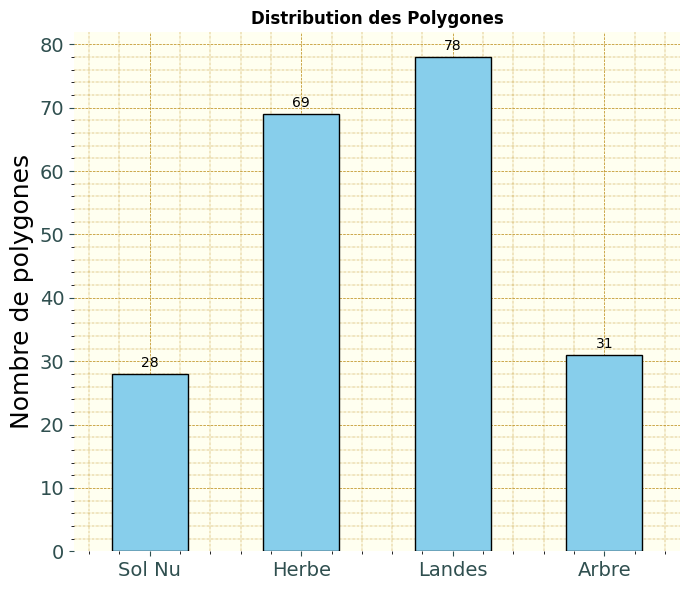

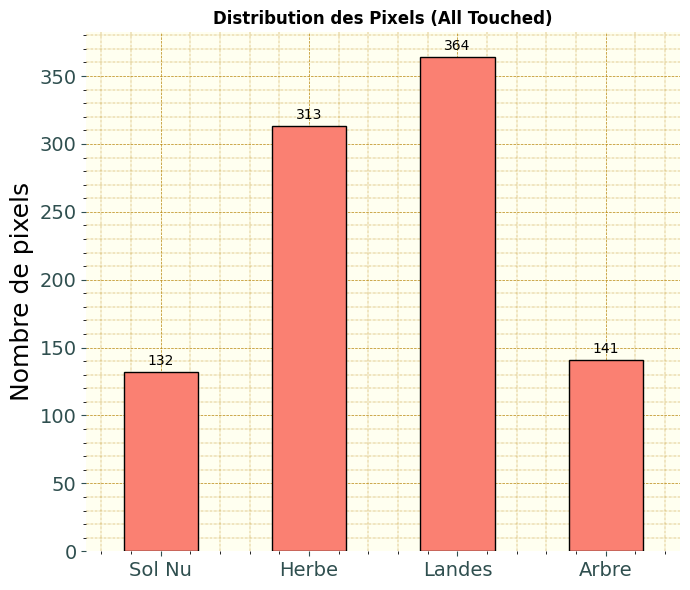

In [2]:
#Rasterisation du shapefile avec pour valeur "strate"
my.rasterize_shapefile(shp_path, b03_path, '../results/strate_raster.tif',
 field="strate")

#Rasterisation du shapefile avec pour valeur "id" (pour discriminer les 
# polygones)
my.rasterize_shapefile(shp_path, b03_path, '../results/poly_id_raster.tif',
 field="id")

# On coupe les alertes spécifiques aux polices de matplotlib
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", message=".*font family.*not found.*")

# Appel de la fonction pour tracer les barplots de description des données 
# d'entrée
my.analyser_donnees_entree(shp_path, '../results/strate_raster.tif')

**Avant de commenter ces deux graphiques, il est essentiel de comprendre la méthode de comptabilisation des pixels par strate.**

La rasterisation a été réalisée selon le principe de la sélection par intersection (**All Touched**). Contrairement à une sélection restrictive basée uniquement sur le centre du pixel, cette option attribue un pixel de 10 m × 10 m à une strate dès qu’une partie, même minimale, de sa surface **intersecte** un polygone d’entraînement.

Cette approche permet d’**augmenter significativement** le nombre de pixels associés à chaque strate, garantissant ainsi que l’ensemble des éléments paysagers observés sur le terrain soit pris en compte lors de l’apprentissage du modèle. Elle est particulièrement pertinente pour capturer les zones de transition, les petits objets paysagers ou les éléments linéaires, qui auraient pu être ignorés avec une sélection par centre.

L’analyse de la représentativité de l’échantillonnage met en évidence plusieurs points clés :

-> **Ratio pixels/polygone** : il est en moyenne de 4.6, ce qui traduit la petite taille des polygones d’échantillonnage devant la résolution spatiale des rasters.

-> **Stratégie de validation** : le déséquilibre numérique entre les classes justifie l’utilisation du StratifiedGroupKFold. Cette méthode garantit que chaque classe, y compris les classes minoritaires, est représentée de manière équitable dans les séparations lors de la validation croisée, assurant ainsi la robustesse et la fiabilité des scores de précision finaux.



---

## **3. Calcul de l’indice ARI (Anthocyanin Reflectance Index)**

### Objectif

Ce bloc a pour objectif de **calculer l’indice ARI** à partir des bandes Sentinel-2 B03 (vert) et B05 (red-edge), puis de sauvegarder le résultat sous forme de raster multi-bandes. L’ARI est un indice spectral utilisé pour détecter la présence d’anthocyanes dans la végétation, et constitue une variable supplémentaire utile pour la classification supervisée.

In [3]:

# Ouverture des bandes Sentinel-2 B03 (Green) et B05 (Vegetation Red Edge) en tant que datasets GDAL
ds_b03, ds_b05 = gdal.Open(b03_path), gdal.Open(b05_path)

# Calcul de l'indice ARI (Anthocyanin Reflectance Index) pour l'ensemble de la série temporelle
# La fonction renvoie un tableau 3D (lignes × colonnes × dates/bandes)
ari_stack = my.calcul_ari_serie(ds_b03, ds_b05)

# Création d'un fichier raster GeoTIFF pour sauvegarder rapidement l'ARI
# Cette sauvegarde est nécessaire pour que d'autres fonctions (ex. cl.get_samples_from_roi) puissent accéder aux valeurs
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(
    ari_path,                 # Chemin de sortie du fichier ARI
    ds_b03.RasterXSize,       # Nombre de colonnes identique à B03
    ds_b03.RasterYSize,       # Nombre de lignes identique à B03
    ds_b03.RasterCount,       # Nombre de bandes identique à B03
    gdal.GDT_Float32          # Type de données flottant 32 bits pour conserver la précision
)

# Attribution des informations géoréférencées du raster B03 au raster ARI
out_ds.SetGeoTransform(ds_b03.GetGeoTransform())  # Transformation géographique (origine, pixel size)
out_ds.SetProjection(ds_b03.GetProjection())      # Système de projection (CRS)

# Boucle sur chaque bande/date pour écrire les valeurs de l'ARI dans le raster de sortie
for i in range(ds_b03.RasterCount):
    out_ds.GetRasterBand(i+1).WriteArray(ari_stack[:, :, i])

# Fermeture du raster pour finaliser l'écriture et libérer la mémoire
out_ds = None


---

## **4. Préparation des données et suivi phénologique**

### Objectif

Ce bloc a pour objectif de **préparer les données d’entrée pour la classification** et d’analyser la **phénologie à partir de l’indice ARI**.  
Il combine l’extraction des pixels par strate, le filtrage des valeurs valides, et la visualisation de l’évolution temporelle des strates à l’aide de l’ARI.

### Contenu du bloc

Les opérations réalisées sont les suivantes :

**Extraction multidimensionnelle** (X, Y, Groups) : Le script parcourt l'ensemble de la pile temporelle (bandes Sentinel-2 et indice ARI) pour extraire les valeurs des pixels situés sur les zones d'entraînement. Il génère simultanément le vecteur des classes cibles (Y) et les identifiants de groupes (Groups) nécessaires à la validation croisée.

**Nettoyage et structuration de la matrice** : Un masque est appliqué pour éliminer les pixels hors zone d'étude ou sans étiquette. Les données sont ensuite nettoyées des valeurs manquantes (NaN) et empilées pour former une matrice de valeurs prête à être soumise à l'algorithme d'apprentissage.

**Suivi de la phénologie** (Indice ARI) : Une visualisation graphique est générée pour tracer les courbes d'évolution de l'indice ARI (Anthocyanin Reflectance Index) sur 10 dates, de octobre 2024 à août 2025. Cela permet d'observer un cycle saisonnier de chaque strate végétale.


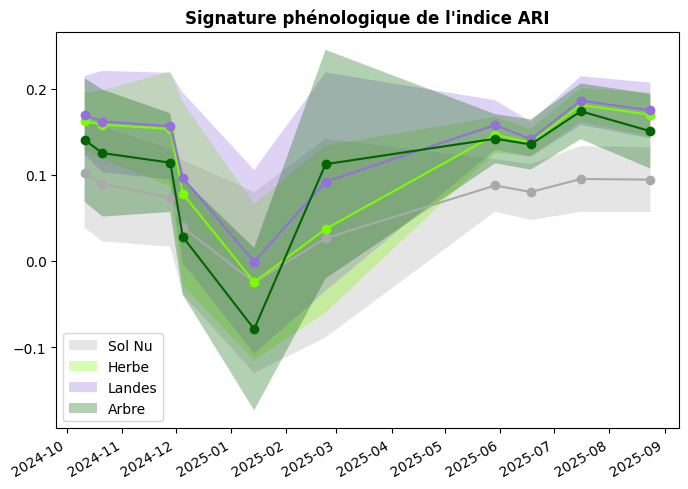

In [4]:
# Ici, on récupère uniquement les valeurs de pixels (index [0])
X_list = [
    cl.get_samples_from_roi(c, '../results/strate_raster.tif')[0] 
    for c in liste_fichiers_bandes + [ari_path]  # toutes les bandes + ARI
]

# Récupération des classes cibles (y) depuis la première bande
# Ravel() transforme le tableau 2D en vecteur 1D
Y = cl.get_samples_from_roi(liste_fichiers_bandes[0],
                            '../results/strate_raster.tif')[1].ravel()

# Récupération des identifiants de polygones pour la validation groupée
groups = cl.get_samples_from_roi('../results/poly_id_raster.tif',
                                 '../results/strate_raster.tif')[0].ravel()

# Création d'un masque pour ne conserver que les pixels ayant une classe > 0
mask = (Y > 0)

# Construction des matrices finales d'apprentissage :
# - X_c : valeurs des pixels pour toutes les bandes et ARI, avec NaN remplacés par 0
# - Y_c : classes correspondantes
# - G_c : identifiants de polygone correspondants
X_c, Y_c, G_c = np.nan_to_num(np.hstack(X_list)[mask]), Y[mask], groups[mask]

# Liste complète des dates correspondant à la série temporelle
dates_completes = [
    "2024-10-11", "2024-10-21", "2024-11-28", "2024-12-05",
    "2025-01-14", "2025-02-23", "2025-05-29", "2025-06-18",
    "2025-07-16", "2025-08-24"
]

# Tracé de la signature phénologique ARI pour chaque classe
# On utilise uniquement les valeurs ARI (dernière entrée de X_list) et le masque de pixels valides
my.tracer_phenologie_ari(X_list[-1][mask], Y_c, dates_completes)

### **Comportement de l'ARI des différentes strates dans le temps**

L'analyse des **signatures phénologiques** issues de l'indice ARI (Anthocyanin Reflectance Index) permet de distinguer les quatre strates de végétation, chacune présentant une réponse pigmentaire unique aux variations saisonnières des Pyrénées.

**La strate « Sol Nu »** : 
La strate « sol nu » présente les valeurs d'ARI les plus faibles et les plus stables de toute la série chronologique. Contrairement aux strates biologiques, le minéral ne possède pas de pigments actifs, ce qui traduit des variations saisonnières plus faibles. L’écart avec les autres strates atteint son maximum durant la période estivale.

Comportement global des **strates végétalisées**
Les strates « landes », « herbes » et « arbres » partagent un cycle saisonnier plus complexe, marqué par un minimum thermique en janvier. Ce creux s'explique par le stress physiologique intense subi par les plantes (températures négatives) ou par la présence d'un manteau neigeux masquant la signature pigmentaire. À l'**automne**, une hiérarchie s'installe : les landes dominent, suivies par l'herbe, puis les arbres, illustrant des **rythmes de sénescence** (vieillissement des feuilles) différenciés.

**La strate « Landes » : Dominance pigmentaire**
La strate « landes » (arbrisseaux bas) affiche globalement l'ARI le plus élevé de l'année. Sa reprise après le minimum de janvier est progressive : elle entame une phase de croissance longue pour atteindre son plateau de maturité pigmentaire en mai. 

**La strate « Herbe » : Une dynamique parallèle**
La signature de l'herbe suit une trajectoire parallèle à celle des landes, mais avec une intensité systématiquement inférieure. Un point de bascule majeur est observé fin février : l'herbe se distingue alors radicalement de la strate arborée avec un ARI proche de 0,25, contre seulement 0,125 pour les arbres. Cette divergence précoce suggère un redémarrage de l'activité métabolique des pelouses alpines dès les premiers redoux, bien avant celui des ligneux hauts.

**La strate « Arbres » : Une réactivité hivernale brutale**
La strate arborée se distingue par une instabilité hivernale marquée. On observe un pic bas fin et brutal durant l'hiver. La chute est rapide, mais la remontée l'est tout autant : l'indice passe de -0,05 le 14/01/2025 à 0,125 le 23/02/2025. Cette forte amplitude témoigne d'une sensibilité accrue des strates hautes aux variations climatiques de début d'année, marquant une rupture nette avec la relative inertie des strates basses (landes et herbes) durant cette même période.

<hr style="border-top: 1px dotted #999;">

<h3 style="text-align: center; color: red;"><em>Choix des variables d'entraînement</em></h3>

Le choix des variables d'entraînement s'est porté sur les **10 bandes Sentinel-2** disponibles dans le jeu de données ainsi que sur l'indice **ARI**.  
Chaque variable contient une valeur par pixel et **par date**, ce qui porte le nombre total de variables utilisées pour entraîner le modèle à **110**.  

Une tentative a été faite pour ajouter la **différence d'ARI** entre les dates **"2025-01-14"** et **"2025-02-23"** afin de capturer la dynamique hivernale précoce, mais cette nouvelle variable n'a pas permis **d'améliorer les métriques de performance** du modèle et n'a donc pas été conservée.

<hr style="border-top: 1px dotted #999;">


---
## **5. Entraînement du modèle et validation croisée**

### Objectif

Ce bloc a pour objectif de **construire, optimiser et évaluer un modèle de classification supervisée** à partir des données extraites et préparées précédemment.  
Il utilise un **Random Forest** et applique une **validation croisée par la fonction StratifiedGroupKfold**, adaptée aux groupes de polygones pour éviter le surapprentissage spatial.


In [5]:
ma_grille = {
    'n_estimators': [50, 100,150, 200, 300],
    'max_depth': [None, 10,15, 20],
    'max_features': [None,'sqrt', 'log2'],
    'min_samples_leaf': [1, 5]
}

<hr style="border-top: 1px dotted #999;">

<h3 style="text-align: center; color: red;"><em>Justification de la grille d'hyperparamètres</em></h3>

La recherche par grille (**GridSearchCV**) permet d'ajuster les hyperparamètres du classifieur Random Forest afin de maximiser les performances tout en limitant le risque de sur-apprentissage (**overfitting**). Voici le rôle et la logique de chaque paramètre testé :  

**n_estimators ([50, 100, 150, 200, 300])** : nombre d'arbres dans la forêt. Plus ce nombre est élevé, plus les prédictions sont stables et robustes, mais le temps d'entraînement augmente. Nous testons jusqu'à 300 arbres pour identifier le point où l'ajout d'arbres supplémentaires n'améliore plus significativement la précision, optimisant ainsi le compromis entre performance et temps de calcul.  

**max_depth ([None, 10, 15, 20])** : profondeur maximale des arbres. Une profondeur illimitée (None) peut capturer des relations complexes mais favoriser le sur-apprentissage. Les valeurs intermédiaires permettent de limiter la complexité et d'améliorer la généralisation du modèle sur des zones géographiques non échantillonnées.  

**max_features ([None, 'sqrt', 'log2'])** : nombre de variables considérées à chaque nœud pour déterminer une coupure.  
- `'sqrt'` et `'log2'` introduisent de la diversité entre les arbres et réduisent la corrélation entre eux.  
- `None` force l'utilisation de toutes les variables (bandes et dates) à chaque nœud, ce qui est utile en télédétection, car certaines dates clés peuvent être particulièrement discriminantes.  

**min_samples_leaf ([1, 5])** : nombre minimum d'échantillons (pixels) dans un nœud terminal. Passer de 1 à 5 permet de lisser la prédiction et d'éviter que le modèle ne crée des règles basées sur un seul pixel bruité ou un artefact atmosphérique sur une image Sentinel-2.  

**n_splits = 5 pour la validation croisée initiale** : le choix d'un nombre de découpages modéré, complété par une validation **StratifiedGroupKFold** sur 30 itérations, constitue une stratégie rigoureuse. Cette double validation permet de compenser la variabilité des données de montagne (pentes, ombres portées, hétérogénéité des peuplements), fournissant à la fois une performance moyenne fiable et une estimation de la stabilité du modèle. En isolant systématiquement les polygones complets lors de chaque test, les scores reflètent la capacité réelle du modèle à cartographier la végétation sur l'ensemble du territoire d'étude.

<hr style="border-top: 1px dotted #999;">


In [6]:
# Entraînement et validation du modèle Random Forest avec la grille d'hyperparamètres définie
modele_final, stats, params = my.entrainement_et_validation(
    X_c, Y_c, G_c, ma_grille)

# Affiche le nombre de variables utilisées par le modèle final
print(f"Le modèle a été entraîné avec {modele_final.n_features_in_} variables.")

# Affiche les meilleurs hyperparamètres trouvés par GridSearchCV
print(f"Meilleurs paramètres : {params}")

Le modèle a été entraîné avec 110 variables.
Meilleurs paramètres : {'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 100}


### **Meilleurs paramètres du modèle Random Forest**

Après optimisation via **GridSearchCV**, les paramètres offrant la meilleure performance sont les suivants :  

- **max_depth = None** : les arbres ne sont pas limités en profondeur, ce qui permet de capturer des relations complexes entre les variables, tout en restant encadré par le nombre minimum d'échantillons par feuille.  
- **max_features = None** : toutes les variables (bandes et indices ARI) sont examinées à chaque nœud, favorisant l'utilisation complète des informations disponibles pour la prédiction.  
- **min_samples_leaf = 5** : chaque feuille terminale contient au moins 5 pixels, ce qui permet de lisser les prédictions et de limiter l'impact des pixels aberrants ou bruités.  
- **n_estimators = 100** : la forêt est composée de 100 arbres, un compromis entre robustesse des prédictions et temps de calcul.  

Ces paramètres garantissent un bon équilibre entre **performance**, **robustesse** et **généralisation spatiale** du modèle sur les données Pyrénéennes.


<hr style="border-top: 1px dotted #999;">
<h3 style="text-align: center; color: red;"><em>Justification de la validation par StratifiedGroupKFold</em></h3>

La validation du modèle se fait sur une procédure de validation croisée via la fonction StratifiedGroupKFold. 

**n_splits=30** : Plutôt que de tester le modèle une seule fois, nous répétons l'opération de division "Entraînement/Test" 30 fois. En télédétection, une seule partition peut être biaisée par un tirage "facile" ou "difficile" de polygones. La répétition permet d'obtenir une distribution statistique des scores (moyenne et écart-type), assurant que la précision est stable et représentative, et non le fruit du hasard.

**test_size=0.2 (20 %)** : À chaque itération, 20 % des groupes (polygones) sont mis de côté pour le test, tandis que 80 % servent à l'entraînement

Le rôle du regroupement par "Groupes" : Le *GroupKFold*, tout comme *GroupShuffleSplit* (pas utilisé ici), respecte l'intégrité des polygones. Si un polygone est choisi pour le test, tous ses pixels sont envoyés dans le jeu de test. Sans cette précaution, le modèle pourrait "apprendre" la signature d'un pixel et être testé sur son voisin immédiat (très similaire), ce qui conduirait à une surestimation  de la précision (biais spatial).
<hr style="border-top: 1px dotted #999;">

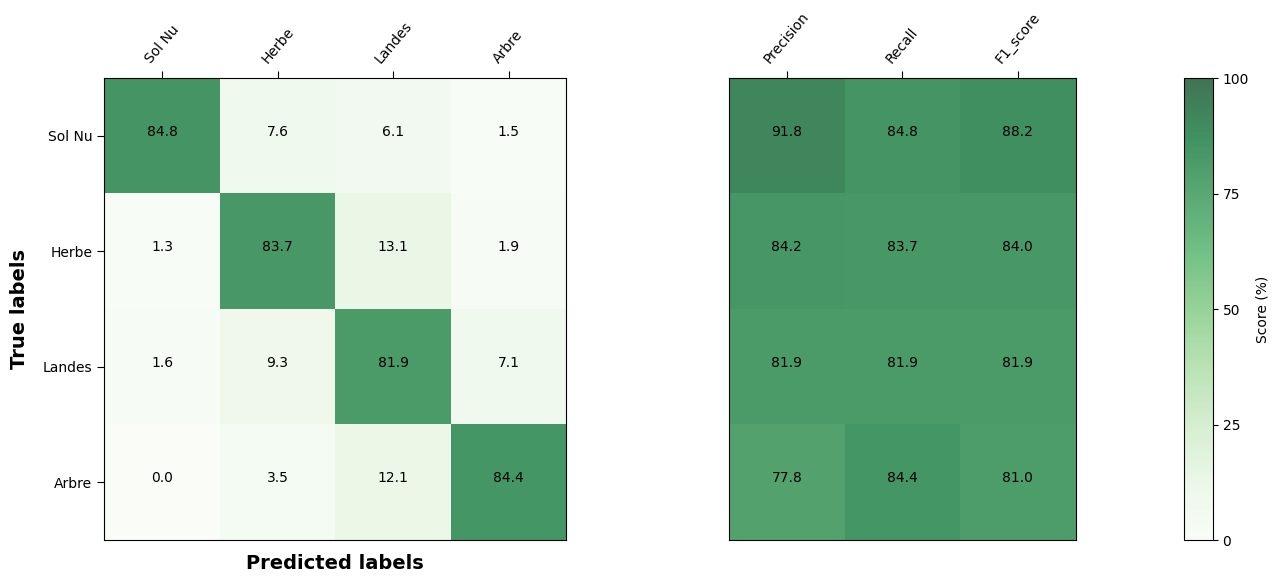

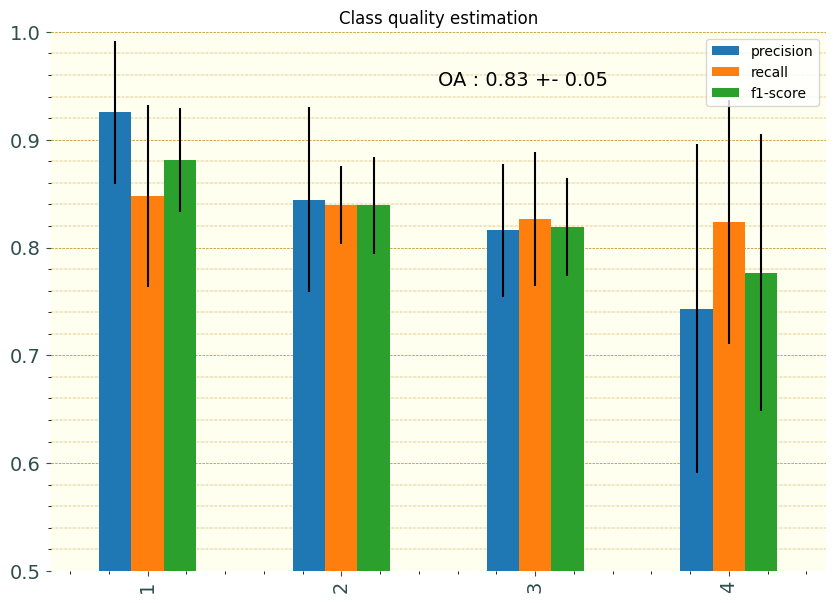

In [7]:
my.afficher_bilan_performances(stats)

### **Matrice de confusion moyenne sur 30 itérations**

**Classe Sol Nu** : Le modèle affiche une solide performance avec 84,8 % de prédictions correctes. Les erreurs de classement se dirigent principalement vers l'Herbe (7,6 %) et les Landes (6,1 %), tandis que la confusion avec les Arbres reste très marginale (1,5 %).

**Interactions Herbe / Landes** : Ces deux classes de végétation basse constituent le principal pôle de confusion du modèle. On observe un flux croisé significatif : 13,1 % de l'Herbe est classée en Landes, et réciproquement, 9,3 % des Landes sont identifiées comme de l'Herbe.

**Classe Landes** : Bien que cette classe obtienne un score de rappel de 81,9 %, elle est la plus "instable". Outre sa confusion avec l'herbe, elle enregistre un report de 7,1 % vers la catégorie Arbre. C'est toutefois la classe qui présente le plus de régularité face au Sol Nu (seulement 1,6 % d'erreur).

**Classe Arbre** : Avec 84,4 % de réussite, cette classe est bien identifiée. Les erreurs se concentrent quasi exclusivement sur les Landes (12,1 %), ce qui souligne une difficulté du modèle à distinguer les strates végétales hautes. À noter qu'il n'existe aucune confusion (0,0 %) entre les Arbres et le Sol Nu.

**Synthèse de la distribution des erreurs** :

L'analyse montre que les erreurs de prédiction sont étroitement liées à la proximité structurelle et spectrale des classes de végétation (Herbe, Landes, Arbre). Les confusions sont minimales, voire nulles, entre les classes aux caractéristiques opposées, comme le Sol Nu et les Arbres, confirmant la cohérence globale du modèle.

### **Performances de la classification** :

L'analyse des performances de la classification, évaluée par validation croisée sur 30 itérations, indique une précision globale (OA) de $0,83 \pm 0,05$. L’examen des métriques par catégorie révèle une hétérogénéité dans la discrimination des couverts : la classe Sol Nu présente les scores les plus élevés avec un F1-score de $0,89$, tandis que les classes Herbe et Landes affichent des performances proches (respectivement $0,81$ et $0,82$). La classe Arbre enregistre les valeurs les plus basses (F1-score de $0,79$).

---
### **6. Importance des variables**

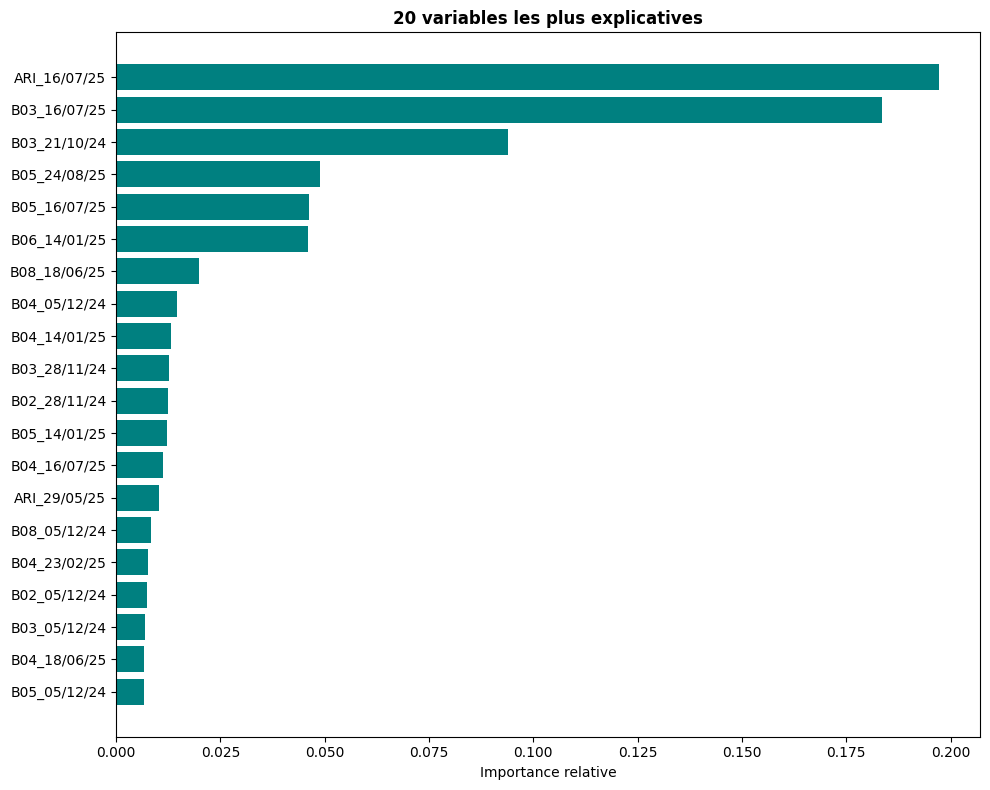

In [8]:
# Création de la liste des noms de variables (features) utilisées pour le modèle.
# Pour chaque bande spectrale Sentinel-2 (B02 à B12, y compris B8A), on crée une variable par date d'acquisition.
# On ajoute également l'indice ARI (Anthocyanin Reflectance Index) pour chaque date.
noms_feats = [f"{b}_{d}" for b in ["B02","B03","B04","B05","B06","B07","B08",
"B8A","B11","B12"] for d in dates] + [f"ARI_{d}" for d in dates]

# Affichage de l'importance de chaque variable dans le modèle final
my.afficher_importance(modele_final, noms_feats)


### **Importance des variables**
L’analyse de l’importance des variables, illustrée par le classement des vingt variables les plus contributives au modèle, met en évidence une prédominance des bandes spectrales et indices acquis en période estivale et de fin de printemps. La variable la plus influente correspond à l'ARI acquise le 16/07/25, suivie par la bande B03 de la même date et par la bande B03 du 21/10/24, soulignant le rôle majeur des informations liées au vert et aux pigments chlorophylliens dans la discrimination des classes.  La présence de variables issues de dates différentes, couvrant le printemps, l’été et le début de l’automne, indique que la dimension temporelle contribue significativement aux performances du modèle, en capturant les variations phénologiques des couverts.

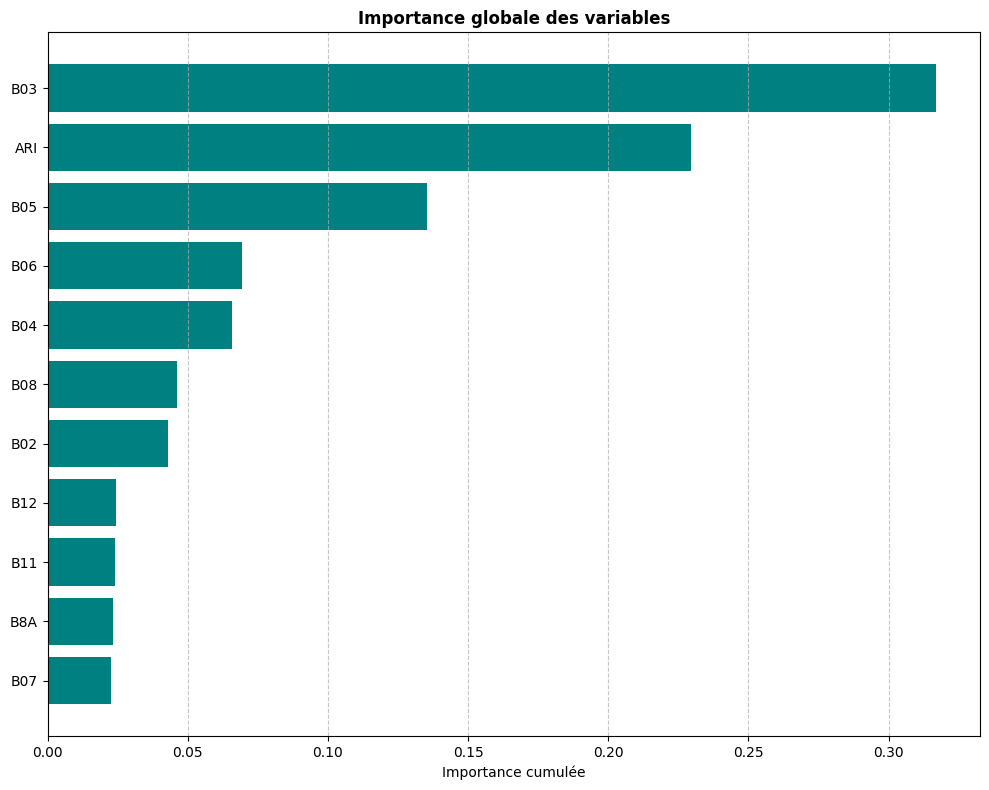

In [9]:
# Global
my.afficher_importance_globale(modele_final, noms_feats)

Ce graphique reste cohérent avec le précédent. Il montre de nouveau l'importance des bandes dans le vert et dans le proche infrarouge dans la discrimination des strates étudiée.

---
### **7. Création de la carte finale**

On passe du modèle statistique au résultat géographique.

**Prédiction spatiale** : Le modèle est appliqué à chaque pixel de l'image d'origine pour générer la carte de végétation finale.

Visualisation : Le dernier bloc affiche la carte avec une palette de couleurs normalisée, offrant une vision spatiale de la répartition des strates sur le massif des Pyrénées.

In [10]:
# Génération de la carte "résultat" de la classification au format tif

my.generer_carte_finale(modele_final, liste_fichiers_bandes, ari_path,
 '../results/carte_strates.tif')

Carte sauvegardée : ../results/carte_strates.tif


---
### **8. Evaluation visuelle de la classification**

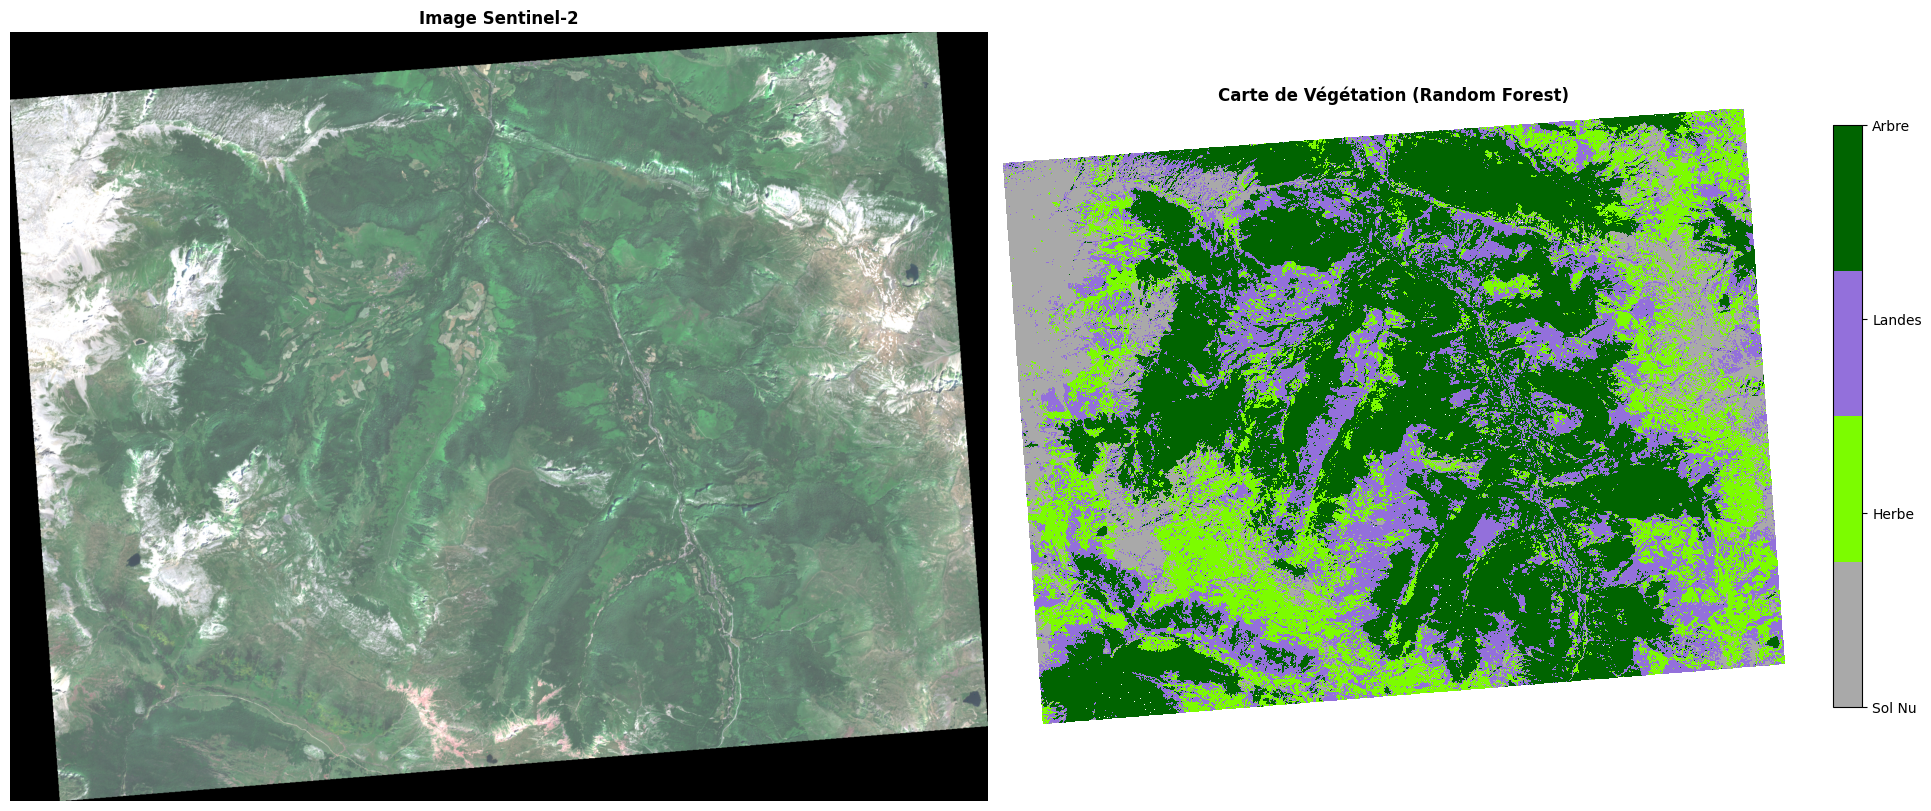

In [11]:
# Fonction de comparaison entre l'image sentinel-2 en vaies couleurs et la carte de classification
my.afficher_comparaison_finale([b04_path, b03_path, b02_path],
 '../results/carte_strates.tif')

### Discussion sur la qualité du modèle entraîné :
Le modèle entraîné démontre des **performances globales satisfaisantes** avec une précision globale (Overall Accuracy, OA) de **0,83 ± 0,05**, obtenue par validation croisée stratifiée avec groupes (StratifiedGroupKFold) sur **30 itérations et 5 plis**, garantissant ainsi une évaluation robuste et représentative des capacités de généralisation du modèle.
**Performances par classe**
L'analyse de la matrice de confusion révèle que les classes "Sol Nu" et "Herbacé" présentent les meilleures performances avec des taux de classification correcte plus élevés.

#### Confusions inter-classes :
Les confusions inter-classes les plus notables s'observent entre **"Herbacé"** et **"Sol Nu"**
**"Landes" et "Herbacé"**

Ces confusions suggèrent une **similarité spectrale** entre ces classes végétales adjacentes de couverture du sol.

#### Déséquilibre des classes :
Les barplots de la première partie indique un **déséquilibre** dans la distribution des échantillons, avec une sous-représentation de la classe "Arbre" par rapport à "Herbacé" (ratio approximatif de 1:2), ce qui pourrait expliquer partiellement la variabilité observée dans les performances.

#### Stabilité du modèle :
Le graphique de qualité par classe confirme une **homogénéité des métriques**, avec des scores F1 compris entre **0,78 et 0,85** pour l'ensemble des classes. Les barres d'erreur attestent d'une stabilité acceptable des performances à travers les 150 configurations de validation testées (30 itérations × 5 plis), confortant ainsi la fiabilité du modèle pour une application opérationnelle de classification d'occupation du sol.

### Analyse visuelle de la classification :
En comparant les deux images disponibles dans le répertoire img, on constate que les zones homogènes, composées uniquement de sol nu par exemple (comme dans le triangle vert au nord-ouest), semblent parfaitement classées. Cela pourrait expliquer les bonnes performances observées pour la classe sol nu.

En revanche, les zones moins homogènes, comme dans l’ovale orange, apparaissent plus difficiles à classifier. Des confusions sont visibles au niveau des jointures entre les différentes strates. 
De plus, le chemin visible sur l’image est parfois mal classé (comme lande au lieu de sol nu), et certaines crêtes, identifiables à l’œil nu comme du sol nu, sont parfois attribuées à la classe landes.

Ainsi, bien que certaines observations confirment les résultats positifs des métriques de performance du modèle, d’autres mettent en évidence des erreurs clairement identifiables dans la classification de la strate sol nu. 

### Conclusion
En somme, le modèle développé présente un niveau de performance robuste et équilibré pour la classification d'occupation du sol, avec une précision globale de 83% et des performances homogènes entre les classes (F1-scores > 0,79). Bien que des améliorations puissent être envisagées, notamment concernant le rééquilibrage des classes d'entraînement et de nouvelles variables intégrables. Le NDVI, souvent utilisé pour détecter la vigueur de la végétation pourrait être une bonne variable intégrable au modèle. De plus, l'entraînement et la validation de ce modèle a été fait sur une zone géographique restreinte. Il est donc difficile de conclure sur sa capacité à décrire les strates d'autres régions du monde. En effet, Il serait peut être intéressant de tester le modèle sur une autre région comme la Bretagne par exemple.

Dans le cadre de notre mission, les cartes produites peuvent être exploitées pour délimiter les zones prioritaires à entretenir, comme les landes, ou pour identifier les zones de sol nu présentant un risque accru d’érosion. La localisation précise des strates végétales permet également de planifier les activités de pâturage en fonction des saisons, afin d’éviter le surpâturage et de préserver la végétation. Par ailleurs, les zones présentant un fort risque d’incendie peuvent être repérées, permettant d’adapter les protocoles de prévention et d’intervention en cas de départ de feu.

Plus généralement, ces cartes pourraient constituer un jeu de données validé, pouvant servir à entraîner d’autres modèles de télédétection ou à comparer différentes méthodes de classification, renforçant ainsi leur utilité pour la recherche et la gestion opérationnelle du territoire.